# Plan

1. Take in a "song name" and "artist name"
2. Fetch the lyrics [API]
3. Split the lyrics into sections (intro, verse, chorus, bridge, etc.)
4. (Optional) Summarize into one sentence [LLM] - Might help with the text-to-image process
5. Create image for every section [LLM]

#Options

- Lyrics Fetch
  - Musixmatch (API)
  - Lyric.ovh (API)
  - Lyric Find
  - Genius
  - serp (API + manual parsing)
  - serp + chatgpt (API + auto parsing)

NOTE: Bonus for section segmentation



## Fetching the lyrics

In [ ]:
!pip install pymusixmatch

  Preparing metadata (setup.py) ... done
  Created wheel for pymusixmatch: filename=pymusixmatch-0.3-py3-none-any.whl size=5851 sha256=5b6300b8ed4423581f5bd13973aae4074488a8197fbe549894015cf4df5b6748
  Stored in directory: /root/.cache/pip/wheels/f6/4a/3d/363c797868dd139e1fcff2470ada9b005b1019ec2051be3fb9
Successfully built pymusixmatch


In [ ]:
class Song:
  def __init__(self, client, song_name, artist_name):
    self.song_input = song_name
    self.artist_input = artist_name
    self.client = client

    self.error = None

    self.track_id = None
    self.track_name = None
    self.artist_name = None

    self.lyrics = None

  # Attempt to retrieve lyrics, returns whether the retrieval is successful
  def exec(self):
    tracks = self.client.track_search(q_track=self.song_input, q_artist=self.artist_input, page_size=10, page=1, s_track_rating='desc')
    track_list = tracks['message']['body']['track_list']
    simplified_track_list = [{ 'track_id': t['track']['track_id'], 'track_name': t['track']['track_name'], 'artist_name': t['track']['artist_name'], 'has_lyrics': t['track']['has_lyrics'] } for t in track_list]
    simplified_track_list = [t for t in simplified_track_list if t['has_lyrics'] == 1]
    track = simplified_track_list[0] if len(simplified_track_list) > 0 else None
    if track is None:
      self.error = 'Cannot found track'
      return False
    else:
      self.track_id = track['track_id']
      self.track_name = track['track_name']
      self.artist_name = track['artist_name']

      lyrics_response = self.client.track_lyrics_get(self.track_id)
      lyrics = lyrics_response['message']['body']['lyrics']
      lyrics_body = lyrics['lyrics_body'].replace('\n...\n\n******* This Lyrics is NOT for Commercial use *******', '')

      self.lyrics = lyrics_body
      return True

  # returns either a string (sections separated by \n\n) or a list of sections. Returns None if there is an error.
  def get_lyrics(self, raw=False):
    if self.error is not None:
      return None

    if raw:
      return self.lyrics
    else:
      sections = self.lyrics.split('\n\n')
      return sections

  def get_artist_name(self):
    return self.artist_name

  def get_track_name(self):
    return self.track_name

  def get_error(self):
    return self.error

In [ ]:
from musixmatch import Musixmatch

musixmatch = Musixmatch('<INSERT_YOUR_API_KEY_HERE')

In [ ]:
song_list = [('Taylor Swift', 'Snow on the Beach'), ('Olivia Rodrigo', 'Drivers License'), ('Gracie Abrams', 'Camden'), ('Sia', 'Snowman')]
songs = []

for req in song_list:
  s = Song(musixmatch, req[1], req[0])
  if s.exec():
    songs.append(s)
    print(f'Successfully retrieved lyrics: {req[1]} ({req[0]})')
  else:
    print(f'Failed to retrieve lyrics: {req[1]} ({req[0]})')

Successfully retrieved lyrics: Snow on the Beach (Taylor Swift)
Successfully retrieved lyrics: Drivers License (Olivia Rodrigo)
Successfully retrieved lyrics: Camden (Gracie Abrams)
Successfully retrieved lyrics: Snowman (Sia)


In [ ]:
song1 = songs[0]
print(song1.get_lyrics(raw=True))
print(len(song1.get_lyrics()))

One night, a few moons ago, I
Saw flecks of what could've been lights
But it might just have been you
Passing by unbeknownst to me

Life is emotionally abusive
And time can't stop me quite like you did
And my flight was awful, thanks for asking
I'm unglued, thanks to you

And it's like snow at the beach, weird, but it was beautiful
Flying in a dream, stars by the pocketful
You wanting me tonight, feels impossible
But it's comin' down, no sound, it's all around

Like snow on the beach
Like snow on the beach
Like snow on the beach
Like snow, (ah), ah

(1409623864816)
5


## Summarise the lyrics

NOTE: Tested with individual sections and the entire song. Models doesnt seem to work well. Perhaps a limitation between nlu of texts vs lyrics.

In [ ]:
import numpy as np

lyrics = np.array(song1.get_lyrics())

In [ ]:
from transformers import pipeline

text = "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct."
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
# summarizer(text, min_length=5, max_length=20)
summarizer(text)

## Generate Images

In [ ]:
!pip install transformers accelerate scipy safetensors invisible_watermark
!pip install git+https://github.com/huggingface/diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.1 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-zs6mzmp0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-zs6mzmp0
  Resolved https://github.com/huggingface/diffusers to commit 9135e54e768a59ddcf8ad18818d2ffe69ea3a32a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) 

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

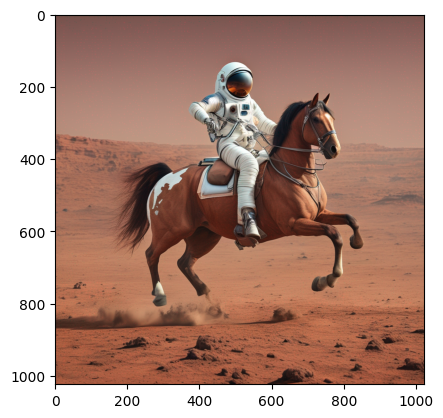

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, DiffusionPipeline, StableDiffusionXLPipeline
import matplotlib.pyplot as plt
import numpy as np

# For SD-2.1
# model_id = "stabilityai/stable-diffusion-2-1"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe = pipe.to("cuda")


# For SD-XL
# model_id = "stabilityai/stable-diffusion-xl-base-1.0"
# pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
# pipe.to("cuda")

# For SSD-1B
pipe = StableDiffusionXLPipeline.from_pretrained("segmind/SSD-1B", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
negative_prompt = "texts, blurry"
image = pipe(prompt=prompt).images[0]

plt.imshow(image)

In [ ]:
lyrics = np.array(song1.get_lyrics())

In [ ]:
output = []
for song in songs:
  print(f'DEBUG: Generating images for song {song.get_track_name()}')
  lyrics = song.get_lyrics()
  song_output = []
  for index, section in enumerate(lyrics):
    raw_text = section.replace("\n", ", ")
    summarized_text = raw_text
    # FIXME: Doesnt seem to work proerply, maybe because the section is too short for the model to get some context
    # summarized_text = summarizer(raw_text, min_length=10, max_length=12)[0]['summary_text']
    # print(summarized_text)
    image_from_raw_text = pipe(prompt=raw_text, negative_prompt="texts, hand-writing, letters, words", num_inference_steps=50).images[0]
    image_from_summarized_text = image_from_raw_text
    # TODO: make the summarizer work
    # image_from_summarized_text = pipe(summarized_text, num_inference_steps=20).images[0]
    song_output.append({
        'raw_text': raw_text,
        'summarized_text': summarized_text,
        'image_from_raw_text': image_from_raw_text,
        'image_from_summarized_text': image_from_summarized_text
    })
  output.append(song_output)

output

DEBUG: Generating images for song Snow On The Beach (feat. Lana Del Rey) [feat. More Lana Del Rey]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

DEBUG: Generating images for song drivers license


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['8 6 4 8 1 6 )']
Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['8 6 4 8 1 6 )']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["what was i thinking looking for a sign?, as if i've ever seen the stars align, somebody take over the drive and, somebody notice how i'm trying, somebody notice how i'm trying"]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["what was i thinking looking for a sign?, as if i've ever seen the stars align, somebody take over the drive and, somebody notice how i'm trying, somebody notice how i'm trying"]


DEBUG: Generating images for song Camden


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

DEBUG: Generating images for song Snowman


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[[{'raw_text': "One night, a few moons ago, I, Saw flecks of what could've been lights, But it might just have been you, Passing by unbeknownst to me",
   'summarized_text': "One night, a few moons ago, I, Saw flecks of what could've been lights, But it might just have been you, Passing by unbeknownst to me",
   'image_from_raw_text': <PIL.Image.Image image mode=RGB size=1024x1024>,
   'image_from_summarized_text': <PIL.Image.Image image mode=RGB size=1024x1024>},
  {'raw_text': "Life is emotionally abusive, And time can't stop me quite like you did, And my flight was awful, thanks for asking, I'm unglued, thanks to you",
   'summarized_text': "Life is emotionally abusive, And time can't stop me quite like you did, And my flight was awful, thanks for asking, I'm unglued, thanks to you",
   'image_from_raw_text': <PIL.Image.Image image mode=RGB size=1024x1024>,
   'image_from_summarized_text': <PIL.Image.Image image mode=RGB size=1024x1024>},
  {'raw_text': "And it's like snow at the be

In [ ]:
max_length = [len(s.get_lyrics()) for s in songs]
songs[0].get_lyrics(raw=True)

"One night, a few moons ago, I\nSaw flecks of what could've been lights\nBut it might just have been you\nPassing by unbeknownst to me\n\nLife is emotionally abusive\nAnd time can't stop me quite like you did\nAnd my flight was awful, thanks for asking\nI'm unglued, thanks to you\n\nAnd it's like snow at the beach, weird, but it was beautiful\nFlying in a dream, stars by the pocketful\nYou wanting me tonight, feels impossible\nBut it's comin' down, no sound, it's all around\n\nLike snow on the beach\nLike snow on the beach\nLike snow on the beach\nLike snow, (ah), ah\n\n(1409623864816)"

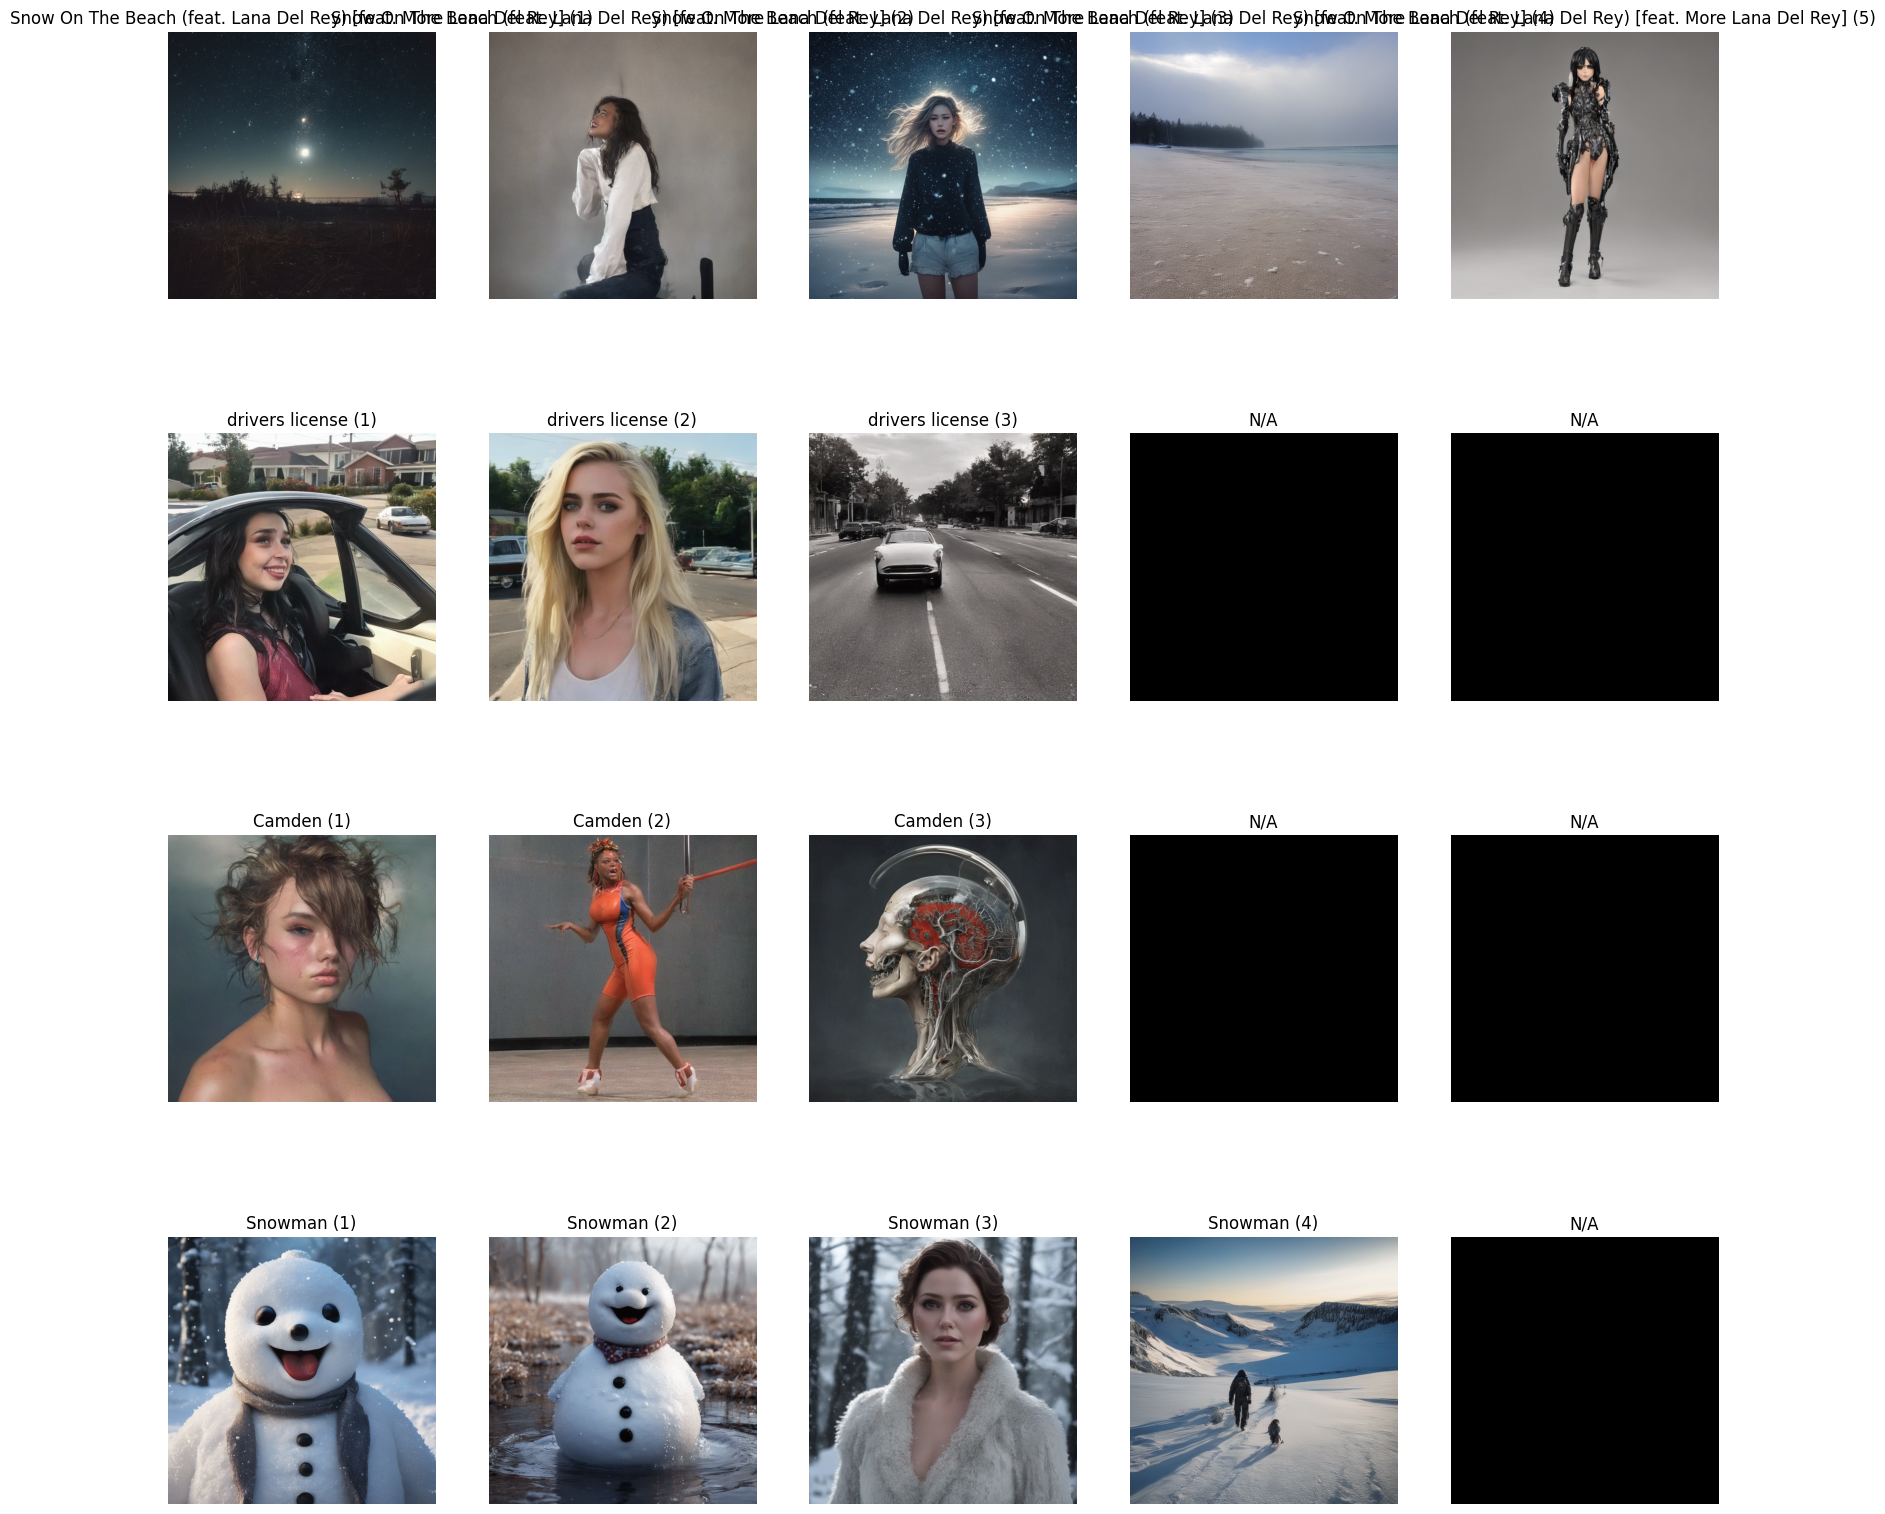

In [ ]:
from PIL import Image

image_dim = 768
max_sections = max([len(s.get_lyrics()) for s in songs]) # song with the most sections
n_rows = len(songs)

# every row represents a song (1 image per section)
_, axs = plt.subplots(n_rows, max_sections, figsize=(20, 20))
axs = axs.flatten()

# images = np.array([[record['image_from_raw_text'], record['image_from_summarized_text']] for record in output])
images = []
metas = []
for index, song in enumerate(output):
  for section_idx, section in enumerate(song):
    images.append(section['image_from_raw_text'])
    metas.append(f'{songs[index].get_track_name()} ({section_idx + 1})')
  # pad images for insufficient sections
  n_paddings = max_sections - len(songs[index].get_lyrics())
  for _ in range(n_paddings):
    images.append(Image.new('RGB', (image_dim, image_dim)))
    metas.append('N/A')


for img, ax, meta in zip(images, axs, metas):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(meta)

plt.show()

In [ ]:
for s in songs:
  print(s.get_track_name(), 'by' ,s.get_artist_name())
  lyrics = s.get_lyrics()
  for l in lyrics:
    print(l)
    print("")
  print("---NEXT---")

Snow On The Beach (feat. Lana Del Rey) [feat. More Lana Del Rey] by Taylor Swift feat. Lana Del Rey
One night, a few moons ago, I
Saw flecks of what could've been lights
But it might just have been you
Passing by unbeknownst to me

Life is emotionally abusive
And time can't stop me quite like you did
And my flight was awful, thanks for asking
I'm unglued, thanks to you

And it's like snow at the beach, weird, but it was beautiful
Flying in a dream, stars by the pocketful
You wanting me tonight, feels impossible
But it's comin' down, no sound, it's all around

Like snow on the beach
Like snow on the beach
Like snow on the beach
Like snow, (ah), ah

(1409623864816)

---NEXT---
drivers license by Olivia Rodrigo
I got my driver's license last week
Just like we always talked about
'Cause you were so excited for me
To finally drive up to your house
But today, I drove through the suburbs
Crying 'cause you weren't around

And you're probably with that blonde girl
Who always made me doubt
She's